## Problem Description
A company's marketing team needs to determine the products to market to each customer in a way that maximizes the marketing campaign return on investment while considering the following constraints:

limits on funding available for the campaign.
restrictions on the minimum number of product offers that can be made in a campaign.
campaign return-on-investment hurdle rates that must be met.

### We are giving sample Data for the model

In [218]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

from matplotlib import pyplot as plt
import random

In [205]:
product_sizes = [5, 10, 15]
cluster_sizes = [5, 10, 15]
customers_count = [100, 1000, 10000, 100000, 500000]

expected_profits_lb = 1000
expected_profits_ub = 4000

costs_per_customer_lb = 80
costs_per_customer_ub = 450

R = 0.20


### Dataset generation

Generate the data with 100, 1000 and 10000 customers with expected profits and costs sampled from the list above.

Generate a Gaussian Distribution for expected profits and costs for the customers


In [219]:
import scipy.stats
random.seed(147)
np.random.seed(147)
## products: 5, clusters: 5, customers: 100

num_products = product_sizes[0]
num_clusters = cluster_sizes[0]


products = ["p"+str(i) for i in range(num_products)]
clusters = ["k"+str(i) for i in range(num_clusters)]
customers = customers_count[0]


"""
To generate minimum quantities of products, random numbers are generated such that the sum of viable products
is equal to a constant number q_sum which depends on the number of customers and number of offered products
"""

##Assuming that atleast 75% of the products should be sold for the campaign to be feasible
q_sum = customers * 0.75

products_min_quant = np.random.multinomial(q_sum, np.ones(len(products))/len(products), size=1)[0]

print(products_min_quant)

[14 16  9 20 16]


In [220]:
import pandas as pd
import random


expected_profit_df = pd.DataFrame()
cost_df = pd.DataFrame()

for i in range(num_products):
    temp_profits = [random.randrange(expected_profits_lb, expected_profits_ub, 200) for t in range(customers)]
    temp_cost = [random.randrange(costs_per_customer_lb, costs_per_customer_ub, 40) for t in range(customers)]
    expected_profit_df[products[i]]=temp_profits
    cost_df[products[i]]=temp_cost
    

print("\nExpected profits for customer for each product")
print(expected_profit_df.head())

print("\nExpected costs for customer for each product")
print(cost_df.head())

print("\nMinimum number of products to be sold")
print(products_min_quant)
    


Expected profits for customer for each product
     p0    p1    p2    p3    p4
0  2800  1200  3000  3400  2000
1  3000  2400  2600  2600  2200
2  1400  3000  2600  3800  3600
3  3800  1400  2600  2000  3400
4  2200  1000  2800  1000  3200

Expected costs for customer for each product
    p0   p1   p2   p3   p4
0  160   80  360  360  400
1  400  280  440  360  120
2  400  360  360  240   80
3  320  200  120  360  240
4  360  120  440  200  320

Minimum number of products to be sold
[14 16  9 20 16]


## Naive Formulation with fixed Budget $B$

$i \in I$: Customer Index and set of customers.

$j \in J$: Index of products and set of products.

### Parameters
$r_{i,j}$: Expected profit given that customer $i \in I$ is offered product $j \in J$.

$\nu_{i,j}$: Average variable cost associated with the offer of product  $j \in J$ to customer $i \in I$.

$Q_{j}$: Minimum number of offers of product $j \in J$. 

$R$: Corporate hurdle rate. Hurdle rate is defined as the minimum <br>
     &nbsp;&nbsp;&nbsp;&nbsp;return on investment for the marketing <br>
     &nbsp;&nbsp;&nbsp;&nbsp;campaign to be vaiable.

$B$: Total marketing campaign budget.

### Decision Variables
$y_{i,j} \geq 0$: Customer $i \in I$ is offered product $j \in J$.


### Objective Function
- **Total profit**. Maximize total expected profit from marketing campaign and heavily penalize any correction to the budget.

\begin{equation}
\text{Max} \quad Z = \sum_{i \in I} \sum_{j \in J} r_{i,j} \cdot y_{i,j}
\tag{0}
\end{equation}

### Constraints


- **Budget**. The total marketing budget is limited by a fixed value $B$ .

\begin{equation}
\sum_{i \in I} \sum_{j \in J} \nu_{i,j} \cdot y_{i,j} \leq B
\tag{2}
\end{equation}

- **Number of offers**. Maximum number of products for each customer should be less than or equal to one.

\begin{equation}
\sum_{j \in J} y_{i,j} \leq 1 \quad \forall i \in i
\tag{1}
\end{equation}


- **Offers limit**. Minimum number of offers of each product.

\begin{equation}
\sum_{i \in I} y_{i,j} \geq Q_{j}  \quad \forall j \in J
\tag{3}
\end{equation}

- **ROI**. The minimum ROI constraint ensures that the ratio of total profits over cost is at least one plus the corporate hurdle rate.

\begin{equation}
\sum_{i \in I} \sum_{j \in J} r_{i,j} \cdot y_{i,j} \geq (1+R) \cdot \sum_{i \in I} \sum_{j \in J} \nu_{i,j} \cdot y_{i,j}
\tag{4}
\end{equation}

where, 
$x_{i,j} \in \{0,1 \}$: This variable is equal to 1, if product $j \in J$  is offered to customer $i \in I$, and 0 otherwise.

In [221]:
#Change exp costs and exp profits to numpy arrays
np_costs = cost_df.to_numpy()
np_exp_profit = expected_profit_df.to_numpy()

"""
Setting the default budget to the average cost of a product multiplied by num of customers to be the budget
"""
budget = 1011805
#(np.sum(np_costs)/np_costs.size)*customers

print("Budget: {}".format(budget))


cust_prods = [('c'+str(i), prod) for i in range(customers) for prod in products]
cust_exp_profits = [np_exp_profit[i][j] for i in range(customers) for j in range(len(products))]
cust_costs = [np_costs[i][j] for i in range(customers) for j in range(len(products))]

Budget: 1011805


In [222]:
#Expected profits from the customers
cust_prods_keys, expected_profit = gp.multidict(dict(zip(cust_prods, cust_exp_profits)))

#Costs for the customers
cust_prods_keys, expected_cost = gp.multidict(dict(zip(cust_prods, cust_costs)))

#Minimum quantities of products to be sold for the campaign to be viable
products, min_offers = gp.multidict(dict(zip(products, products_min_quant)))

### Scalars

The corporate hurdle-rate (return on investment) is twenty percent ($R = 0.20$).

The budget available for the marketing campaign is $\$3000$.

In [223]:
"""
    Scalars used in the problem
    
"""

"""
Hurdle rate: Minimum return on investment expected from the Marketing Campaign. 
"""
R = 0.20 

"""
The budget decided for the marketing campagin. Optimal solution will be infeasible 
if sufficient budget has not been allocated for the campaign. In that case the budget might need to be increased.
"""

'\nThe budget decided for the marketing campagin. Optimal solution will be infeasible \nif sufficient budget has not been allocated for the campaign. In that case the budget might need to be increased.\n'

### Decision Variables
$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

In [130]:
# Declare and initialize model
mt = gp.Model('Naive')

### Decisions variables (cust_prod_keys is either 1 or 0)
y = mt.addVars(cust_prods_keys, vtype=GRB.BINARY, name="assign")

### Constraints

- **Budget**

\begin{equation}
\sum_{k \in K} \sum_{j \in J} \nu_{k,j} \cdot y_{k,j} \leq B
\tag{2}
\end{equation}

Where

$y_{i,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$\nu_{i,j}$: Variable cost associated with the offer of product  $j \in J$ to customer $i \in I$.

$B$: Marketing campaign budget.

In [131]:
const_budget = mt.addConstr((y.prod(expected_cost) <= budget), name='budget')

- **Offers limit**. Minimum number of offers of each product.

\begin{equation}
\sum_{k \in K} y_{k,j} \geq Q_{j}  \quad \forall j \in J
\tag{3}
\end{equation}

In [132]:
const_minOffers = mt.addConstrs( (y.sum('*',j) >= min_offers[j] for j in products), name='min_offers')


- **ROI**.

\begin{equation}
\sum_{i \in I} \sum_{j \in J} r_{i,j} \cdot y_{i,j} \geq (1+R) \cdot \sum_{i \in I} \sum_{j \in J} \nu_{i,j} \cdot y_{i,j}
\tag{4}
\end{equation}

Where

$y_{i,j} \geq 0$: Customer $i \in I$ that are offered product $j \in J$.

$r_{i,j}$: Expected profit from the offer of product $j \in J$ to customer $i \in I$.

$\nu_{i,j}$: Variable cost associated with the offer of product  $j \in J$ to customer $i \in I$.

$R$: Corporate hurdle rate.

In [133]:
# Constraint to ensure minimum ROI

ROI_con = mt.addConstr((y.prod(expected_profit) - (1 + R)*y.prod(expected_cost) >= 0), name='ROI')

**Number of offers**. Maximum number of offers of products for each person should be less than or equal to one.

\begin{equation}
\sum_{j \in J} y_{i,j} \leq 1 \quad \forall i \in i
\tag{1}
\end{equation}

In [68]:
no_offers = mt.addConstrs( (y.sum('c'+str(i),'*') == 1 for i in range(customers)), name='no_offers')

### Objective Function
- **Total profit**

\begin{equation}
\text{Max} \quad Z = \sum_{i \in I} \sum_{j \in J} r_{i,j} \cdot y_{i,j}
\tag{0}
\end{equation}

Where

$y_{i,j} \geq 0$: Customer $i \in I$ offered product $j \in J$.

$r_{i,j}$: Expected profit from product $j \in J$ to customer $i \in I$.

In [69]:
mt.setObjective(y.prod(expected_profit), GRB.MAXIMIZE)

In [70]:
mt.write('naive_cust_assign.lp')

In [71]:
mt.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10012 rows, 100000 columns and 400000 nonzeros
Model fingerprint: 0x6d78d9ef
Variable types: 0 continuous, 100000 integer (100000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 1 rows and 0 columns
Presolve time: 0.45s
Presolved: 10011 rows, 100000 columns, 298985 nonzeros
Variable types: 0 continuous, 100000 integer (100000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.722440e+07, 10769 iterations, 0.25 seconds (0.34 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

In [72]:
print(mt.runTime)
print(mt)

1.162165880203247
<gurobi.Model MIP instance Naive: 10012 constrs, 100000 vars, No parameter changes>


In [197]:
##Generating output reports

# Optimal allocation of product offers to clusters

total_expected_profit = 0
total_expected_cost = 0

print("\nOptimal allocation of product offers to clusters.")
print("___________________________________________________")
for i,p in cust_prods_keys:
    if y[i,p].x > 1e-6:
        #print(y[i,p].varName, y[i,p].x)
        #print(f" Customers {i} gets an offer of product {p}")
        total_expected_profit += expected_profit[i,p]*y[i,p].x
        total_expected_cost += expected_cost[i,p]*y[i,p].x
        

# Financial reports

optimal_ROI = round(100*total_expected_profit/total_expected_cost,2)
min_ROI = round(100*(1+R),2)

money_expected_profit = '${:,.2f}'.format(total_expected_profit)
money_expected_cost = '${:,.2f}'.format(total_expected_cost)
money_budget = '${:,.2f}'.format(budget)

print(f"\nFinancial reports.")
print("___________________________________________________")
print(f"Optimal total expected profit is {money_expected_profit}.")
print(f"Total budget is {money_budget} and the money spent is {money_expected_cost}.")
print(f"Optimal ROI is {optimal_ROI}% with a minimum ROI of  {min_ROI}%.")


Optimal allocation of product offers to clusters.
___________________________________________________


AttributeError: Index out of range for attribute 'X'

In [198]:
budgets = [(80 + i**1.5 + 2*i)*customers for i in range(30)]
"""
See how ROI changes with change in budget
Using fixed data - customers = 10000, clusters = 10, products = 15
"""

'\nSee how ROI changes with change in budget\nUsing fixed data - customers = 10000, clusters = 10, products = 15\n'

In [199]:
def get_ROI_from_Naive_model(budget):
    # Declare and initialize model
    print("------Given budget is - {}---------".format(budget))
    mt = gp.Model('Naive')
    
    #print(cust_prods_keys)
    ### Decisions variables (cust_prod_keys is either 1 or 0)
    y = mt.addVars(cust_prods_keys, vtype=GRB.BINARY, name="assign")
    
    const_budget = mt.addConstr((y.prod(expected_cost) <= budget), name='budget')
    
    const_minOffers = mt.addConstrs( (y.sum('*',j) >= min_offers[j] for j in products), name='min_offers')
    
    no_offers = mt.addConstrs( (y.sum('c'+str(i),'*') == 1 for i in range(customers)), name='no_offers')
    
    mt.setObjective(y.prod(expected_profit), GRB.MAXIMIZE)
    
    mt.optimize()
    
    if mt.status == GRB.OPTIMAL:
        total_expected_profit = 0
        total_expected_cost = 0

        try:
            for i,p in cust_prods_keys:
                #print(y[i,p].x)
                if y[i,p].x > 1e-6:
                    #print(y[i,p].varName, y[i,p].x)
                    #print(f" Customers {i} gets an offer of product {p}")
                    total_expected_profit += expected_profit[i,p]*y[i,p].x
                    total_expected_cost += expected_cost[i,p]*y[i,p].x

        except:
            pass
        # Financial reports

        optimal_ROI = round(100*total_expected_profit/max(total_expected_cost,1e-6),2)

        return total_expected_profit, total_expected_cost, optimal_ROI, mt.runTime
    else:
        return 0,0,0,0
    
    

In [200]:
business_analysis = [get_ROI_from_Naive_model(bud) for bud in budgets]

print(business_analysis)

------Given budget is - 800000.0---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10016 rows, 150000 columns and 450000 nonzeros
Model fingerprint: 0x166e8b8c
Variable types: 0 continuous, 150000 integer (150000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 1.10s
Presolved: 10016 rows, 150000 columns, 449093 nonzeros
Variable types: 0 continuous, 150000 integer (150000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: infeasible, 11309 iterations, 0.53 seconds (0.26 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/


Solution count 1: 3.13608e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.136080000000e+07, best bound 3.136080000000e+07, gap 0.0000%
------Given budget is - 1066969.3845669907---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10016 rows, 150000 columns and 450000 nonzeros
Model fingerprint: 0xba86adf0
Variable types: 0 continuous, 150000 integer (150000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve time: 3.86s
Presolved: 10016 rows, 150000 columns, 449093 nonzeros
Variable types: 0 continuous, 150000 integer (150000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8475800e+

Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.504160e+07, 5548 iterations, 0.28 seconds (0.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.5042e+07    0    2          - 3.5042e+07      -     -    1s
H    0     0                    3.504160e+07 3.5042e+07 -0.00%     -    1s

Explored 1 nodes (5548 simplex iterations) in 1.70 seconds (2.77 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 3.50416e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.504160000000e+07, best bound 3.504160000000e+07, gap 0.0000%
------Given budget is - 1455692.1938165305---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10016 rows, 150000 columns and 450000

Optimize a model with 10016 rows, 150000 columns and 450000 nonzeros
Model fingerprint: 0x63d05a14
Variable types: 0 continuous, 150000 integer (150000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve time: 0.66s
Presolved: 10016 rows, 150000 columns, 449093 nonzeros
Variable types: 0 continuous, 150000 integer (150000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.647613e+07, 1930 iterations, 0.39 seconds (0.47 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.6476e+07    0    2          - 3.6476e+07      -     -    1s
H    0     0                    3.647500e+07 3.6476e+07  0.00%     -    2s

Explo

Thread count was 8 (of 8 available processors)

Solution count 1: 3.69578e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.695780000000e+07, best bound 3.695780000000e+07, gap 0.0000%
------Given budget is - 2363041.2503619255---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10016 rows, 150000 columns and 450000 nonzeros
Model fingerprint: 0x6669df19
Variable types: 0 continuous, 150000 integer (150000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+06]
Presolve time: 0.66s
Presolved: 10016 rows, 150000 columns, 449093 nonzeros
Variable types: 0 continuous, 150000 integer (150000 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root re

  RHS range        [1e+00, 3e+06]
Found heuristic solution: objective 2.401900e+07
Presolve time: 0.60s
Presolved: 10016 rows, 150000 columns, 449093 nonzeros
Variable types: 0 continuous, 150000 integer (150000 binary)
Found heuristic solution: objective 3.667680e+07

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.696600e+07, 1666 iterations, 0.14 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3.696600e+07 3.6966e+07 -0.00%     -    0s

Explored 1 nodes (1666 simplex iterations) in 0.87 seconds (1.76 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 3.6966e+07 3.66768e+07 2.4019e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.696600000000e+07, best bound

In [147]:
def plot_bud_v_roi(budgets, business_analysis):
    plt.plot(budgets, [val[2] for val in business_analysis], color='blue')
    plt.title('Budget vs ROI', fontsize=14)
    plt.xlabel('Budget', fontsize=14)
    plt.ylabel('Return on Investment', fontsize=14)
    plt.grid(True)
    plt.show()

In [148]:
def plot_bud_profit(budgets, business_analysis):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Budget')
    ax1.set_ylabel('Expected Profits', color=color)
    ax1.plot(budgets, [val[0] for val in business_analysis], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Estimated costs', color=color)  # we already handled the x-label with ax1
    ax2.plot(budgets, [val[1] for val in business_analysis], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Budget vs Exp. Profit and Cost', fontsize=14)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

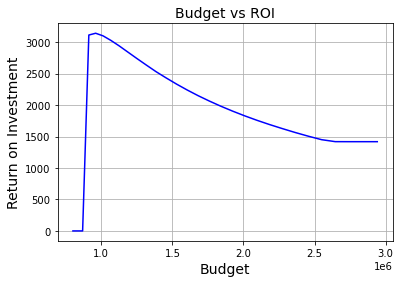

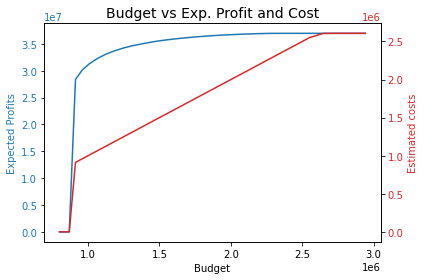

[(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (28383800.0, 911960.0, 3112.4, 5.899490833282471), (30152200.0, 960000.0, 3140.85, 4.6501100063323975), (31360800.0, 1011800.0, 3099.51, 3.2519640922546387), (32299800.0, 1066960.0, 3027.27, 7.709772825241089), (33086200.0, 1125200.0, 2940.47, 4.434167146682739), (33714600.0, 1186240.0, 2842.14, 1.6392428874969482), (34246800.0, 1250000.0, 2739.74, 1.722383975982666), (34692600.0, 1316200.0, 2635.82, 1.7566399574279785), (35041600.0, 1384800.0, 2530.44, 1.6986970901489258), (35394400.0, 1455680.0, 2431.47, 1.9362590312957764), (35674400.0, 1528720.0, 2333.61, 1.8300280570983887), (35917000.0, 1603800.0, 2239.49, 1.6626460552215576), (36121200.0, 1680880.0, 2148.95, 1.6492080688476562), (36317000.0, 1760000.0, 2063.47, 1.925934076309204), (36475000.0, 1840880.0, 1981.39, 2.139847993850708), (36614000.0, 1923640.0, 1903.37, 1.8163909912109375), (36726600.0, 2008120.0, 1828.9, 1.342763900756836), (36822200.0, 2094400.0, 1758.13, 1.273641109466552

In [201]:
plot_bud_v_roi(budgets, business_analysis)
plot_bud_profit(budgets, business_analysis)

print(business_analysis)

### Creating Clusters

In the second approach, we group the customers into clusters and relax the binary constriant of $y_{i,j}. This will relax the problem from MLP to LP. 

We are using KMeans to cluster the data and use the expected_profits to cluster the customers. We also expirement with
expected_costs and expected_profits/expected_costs as well.


In [150]:
from sklearn.cluster import KMeans

km = KMeans(
       init="random",
       n_clusters=num_clusters,
       n_init=10,
       max_iter=300,
       random_state=42
      )

In [151]:
##Take expected profits as the feature to group the customers
##Todo: Experiment with expected costs and expected_profit/expected_cost

cust_clust = km.fit_predict(np_exp_profit)

clusters_exp_profit = km.cluster_centers_

exp_profit_cluster = np.array([None for k in range(num_clusters)])

exp_cost_cluster = np.array([None for k in range(num_clusters)])

clust_cust_exp_profit = {} #Maintain the cluster to customer to product profit mapping
clust_cust_exp_cost = {} #Maintain the cluster to customer to product cost mapping

cluster_cust_map = [] #Maintain the cluster to customer mapping

for i in range(len(cust_clust)):
    
    cluster_cust_map.append(('k'+str(cust_clust[i]), 'c'+str(i)))
    if(exp_profit_cluster[cust_clust[i]]) is None:
        exp_profit_cluster[cust_clust[i]] = np.array(np_exp_profit[i])
    else:
        exp_profit_cluster[cust_clust[i]] = np.vstack([exp_profit_cluster[cust_clust[i]], np_exp_profit[i]])
        
    for j in range(len(products)):
        clust_cust_exp_profit['k'+str(cust_clust[i]),'c'+str(i),products[j]] = np_exp_profit[i][j]
        
    if(exp_cost_cluster[cust_clust[i]]) is None:
        exp_cost_cluster[cust_clust[i]] = np.array(np_costs[i])
    else:
        exp_cost_cluster[cust_clust[i]] = np.vstack([exp_cost_cluster[cust_clust[i]], np_costs[i]])
    
    for j in range(len(products)):
        clust_cust_exp_cost['k'+str(cust_clust[i]),'c'+str(i),products[j]] = np_costs[i][j]
        
"""
Calculate the centroid of the exp_cost_clusters
"""

clusters_exp_cost = np.array([np.mean(cluster, axis = 0) for cluster in exp_cost_cluster])

In [152]:
print(clusters_exp_cost)
print(clusters_exp_profit)

[[259.81981982 259.0990991  256.93693694 262.82282282 261.18118118
  262.18218218 261.86186186 255.45545546 251.13113113 260.5005005
  259.85985986 254.49449449 267.38738739 259.01901902 261.22122122]
 [257.91359326 263.09799789 260.9483667  261.36986301 258.71443625
  261.6227608  255.6796628  262.00210748 260.10537408 257.44994731
  262.80295047 263.30874605 261.0748156  260.82191781 260.56902002]
 [257.19882468 263.38883448 256.84622919 263.66307542 266.20959843
  267.54162586 260.72477963 260.92066601 260.7639569  258.53085211
  256.49363369 255.51420176 266.71890304 264.64250735 260.09794319]
 [257.375      261.5        260.58333333 261.16666667 258.83333333
  258.79166667 258.04166667 262.25       267.16666667 260.16666667
  253.         258.45833333 257.5        262.58333333 260.625     ]
 [257.99242424 262.08333333 258.56060606 261.78030303 258.90151515
  260.26515152 264.96212121 253.33333333 255.75757576 258.90151515
  262.08333333 262.68939394 256.74242424 261.5530303  262.5

## Tactical formulation with fixed budget $B$

### Part 1 : Allocate the number of products for each cluster

$k \in K$: Index of clusters.

$j \in J$: Index of products.

### Parameters
$r_{k,j}$: Expected profit given that customer in cluster $k \in K$ is offered product $j \in J$.

$\nu_{k,j}$: Average variable cost associated with the offer of product  $j \in J$ to customer of cluster $k \in K$.
  
$N_{k}$: Number of customers in cluster $k \in K$.

$Q_{j}$: Minimum number of offers of product $j \in J$. 

$R$: Corporate hurdle rate. Hurdle rate is defined as the minimum return on investment for the marketing campaign to be vaiable.

$B$: Total marketing campaign budget.

### Decision Variables
$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.


### Objective Function
- **Total profit**. Maximize total expected profit from marketing campaign and heavily penalize any correction to the budget.

\begin{equation}
\text{Max} \quad Z = \sum_{k \in K} \sum_{j \in J} r_{k,j} \cdot y_{k,j}
\tag{0}
\end{equation}

### Constraints

- **Number of offers**. Maximum number of offers of products for each cluster should be less than the number of customers in the cluster.

\begin{equation}
\sum_{j \in J} y_{k,j} \leq N_{k} \quad \forall k \in K
\tag{1}
\end{equation}

- **Budget**. The total marketing budget is limited by a fixed value $B$ .

\begin{equation}
\sum_{k \in K} \sum_{j \in J} \nu_{k,j} \cdot y_{k,j} \leq B
\tag{2}
\end{equation}

- **Offers limit**. Minimum number of offers of each product.

\begin{equation}
\sum_{k \in K} y_{k,j} \geq Q_{j}  \quad \forall j \in J
\tag{3}
\end{equation}

- **ROI**. The minimum ROI constraint ensures that the ratio of total profits over cost is at least one plus the corporate hurdle rate.

\begin{equation}
\sum_{k \in K} \sum_{j \in J} r_{k,j} \cdot y_{k,j} \geq (1+R) \cdot \sum_{k \in K} \sum_{j \in J} \nu_{k,j} \cdot y_{k,j}
\tag{4}
\end{equation}



### Expected profit

In [153]:
#Expected profits from the customers
cluster_prods = [('k'+str(i), prod) for i in range(num_clusters) for prod in products]
clusters_exp_profits = [clusters_exp_profit[i][j] for i in range(num_clusters) for j in range(len(products))]

cluster_prods_keys, expected_profit = gp.multidict(dict(zip(cluster_prods, clusters_exp_profits)))

### Expected cost

The expected cost of offering a product to a customer in a cluster is calculated below.


In [154]:
#Costs for the customers
clusters_exp_costs = [clusters_exp_cost[i][j] for i in range(num_clusters) for j in range(len(products))]

cluster_prods_keys, expected_cost = gp.multidict(dict(zip(cluster_prods, clusters_exp_costs)))

### Number of customers

In [155]:
clusters = ['k'+str(i) for i in range(num_clusters)]
number_customers = [len(exp_profit_cluster[i]) for i in range(num_clusters)]

clusters, number_customers = gp.multidict(dict(zip(clusters, number_customers)))
print(number_customers)

{'k0': 999, 'k1': 949, 'k2': 1021, 'k3': 960, 'k4': 1056, 'k5': 947, 'k6': 979, 'k7': 1059, 'k8': 1046, 'k9': 984}


### Minimum number of offers

In [156]:
#Minimum quantities of products to be sold for the campaign to be viable
products, min_offers = gp.multidict(dict(zip(products, products_min_quant)))

### Scalars

The corporate hurdle-rate (return on investment) is twenty percent ($R = 0.20$).

The budget available for the marketing campaign is $\$3000$.


### Decision Variables
$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$z \geq 0$: Increase in budget in order to have a feasible campaign.

In [81]:
# Declare and initialize model
mt_tact = gp.Model('Tactical')

### Decisions variables
y = mt_tact.addVars(cluster_prods_keys, name="allocate")

### Constraints

- **Number of offers**

\begin{equation}
\sum_{j \in J} y_{k,j} \leq N_{k} \quad \forall k \in K
\tag{1}
\end{equation}

Where

$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$N_{k}$: Number of customers in cluster $k \in K$.

In [82]:
### Constraints

# Constraint on number of offers at each cluster

const_maxOffers = mt_tact.addConstrs((y.sum(k,'*') <= number_customers[k]  for k in clusters), name='maxOffers')


- **Budget**

\begin{equation}
\sum_{k \in K} \sum_{j \in J} \nu_{k,j} \cdot y_{k,j} \leq B
\tag{2}
\end{equation}

Where

$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$\nu_{k,j}$: Average variable cost associated with the offer of product  $j \in J$ to an average customer of cluster $k \in K$.

$B$: Marketing campaign budget.

In [83]:
# Budget constraint

const_budget = mt_tact.addConstr((y.prod(expected_cost) <= budget), name='budget')

**Offers limit**
\begin{equation}
\sum_{k \in K} y_{k,j} \geq Q_{j}  \quad \forall j \in J
\tag{3}
\end{equation}

Where

$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$Q_{j}$: Minimum number of offers of product $j \in J$.

In [84]:
const_minOffers = mt_tact.addConstrs( (y.sum('*',j) >= min_offers[j] for j in products), name='min_offers')


- **ROI**.

\begin{equation}
\sum_{k \in K} \sum_{j \in J} r_{k,j} \cdot y_{k,j} \geq (1+R) \cdot \sum_{k \in K} \sum_{j \in J} \nu_{k,j} \cdot y_{k,j}
\tag{4}
\end{equation}

Where

$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$r_{k,j}$: Expected profit to the bank from the offer of product $j \in J$ to an average customer of cluster $k \in K$.

$\nu_{k,j}$: Average variable cost associated with the offer of product  $j \in J$ to an average customer of cluster $k \in K$.

$R$: Corporate hurdle rate.

In [85]:
# Constraint to ensure minimum ROI

ROI_con = mt_tact.addConstr((y.prod(expected_profit) - (1 + R)*y.prod(expected_cost) >= 0), name='ROI')

### Objective Function
- **Total profit**

\begin{equation}
\text{Max} \quad Z = \sum_{k \in K} \sum_{j \in J} r_{k,j} \cdot y_{k,j}
\tag{0}
\end{equation}

Where

$y_{k,j} \geq 0$: Number of customers in cluster $k \in K$ that are offered product $j \in J$.

$r_{k,j}$: Expected profit from product $j \in J$ to customer of cluster $k \in K$.

In [86]:
mt_tact.setObjective(y.prod(expected_profit), GRB.MAXIMIZE)

In [87]:
mt_tact.write('tact_max_profit.lp')

In [88]:
mt_tact.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 17 rows, 50 columns and 200 nonzeros
Model fingerprint: 0x36cd0053
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [2e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 1e+06]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 16 rows, 50 columns, 150 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0129529e+07   3.072240e+04   0.000000e+00      0s

Solved in 14 iterations and 0.01 seconds (0.00 work units)
Infeasible or unbounded model


In [ ]:
### Output Reports

# Optimal allocation of product offers to clusters

total_expected_profit = 0
total_expected_cost = 0

print("\nOptimal allocation of product offers to clusters.")
print("___________________________________________________")
for k,p in cluster_prods_keys:
    if y[k,p].x > 1e-6:
        #print(y[k,p].varName, y[k,p].x)
        print(f"The number of customers in cluster {k} that gets an offer of product {p} is: {y[k,p].x}")
        total_expected_profit += expected_profit[k,p]*y[k,p].x
        total_expected_cost += expected_cost[k,p]*y[k,p].x

# Financial reports

optimal_ROI = round(100*total_expected_profit/total_expected_cost,2)
min_ROI = round(100*(1+R),2)

money_expected_profit = '${:,.2f}'.format(total_expected_profit)
money_expected_cost = '${:,.2f}'.format(total_expected_cost)
money_budget = '${:,.2f}'.format(budget)

print(f"\nFinancial reports.")
print("___________________________________________________")
print(f"Optimal total expected profit is {money_expected_profit}.")
print(f"Optimal total expected cost is {money_expected_cost} with a budget of {money_budget}")
print(f"Optimal ROI is {optimal_ROI}% with a minimum ROI of  {min_ROI}%.")

In [ ]:
mt_tact.runTime

### Part 2: Assigning the products to the customers within each cluster while maintaing cluster constraints. 


Once the optimal values $y_{k,j}$, for all $j \in J$ and $k \in K$, of the Part 1 have been found, we should determine which individual customers in cluster $k$ should get an offer of a product. The optimal way to do that is to solve an assignment problem using the estimated expected profit for the individual customers.


### Sets and Indices
$i \in I^{k}$: Index and set of customers in cluster $k \in K$.

$j \in J^{k}$: Index and subset of products offered to customers in cluster $k \in K$ , where $J^{k} = \{ j \in J: y_{k,j} > 0 \}$ .

### Parameters

$r_{k,i,j}$: Expected individual profit of customer $i \in I^{k}$ from  offer of product $j \in J^{k}$. 

$Y_{k,j} = \lfloor y_{k,j} \rfloor $: Number of customers in cluster k that will get an offer of product $j \in J^{k}$.

### Decision Variables
$x_{k,i,j} \in \{0,1 \}$: This variable is equal to 1, if product $j \in J^{k}$  is offered to customer $i \in I^{k}$, and 0 otherwise.



### Objective Function
- **Total profit**. Maximize total individual profit.

\begin{equation}
\text{Max} \quad Z = \sum_{k \in K} \sum_{i \in I^{k}} \sum_{j \in J^{k}} r_{k,i,j} \cdot x_{k,i,j}
\tag{0}
\end{equation}


### Constraints

- **Product offers**. Allocate offers of a product to customers of each cluster.

\begin{equation}
\sum_{i \in  I^{k}}  x_{k,i,j} = Y_{k,j}  \quad \forall j \in J^{k}, k \in K
\tag{1}
\end{equation}


- **Offers limit**. At most one product may be offered to a customer of a cluster.

\begin{equation}
\sum_{j \in J^{k}} x_{k,i,j} \leq 1 \quad \forall i \in I^{k}, k \in K
\tag{2}
\end{equation}

- **Binary constraints**. Either a product offer is given to a customer of cluster k or not.

\begin{equation}
x_{k,i,j} \in \{0,1 \} \quad \forall i \in I^{k},  j \in J^{k}, k \in K
\tag{3}
\end{equation}


### Customer expected profit

In [157]:
ccp, customer_profit = gp.multidict(clust_cust_exp_profit)

### Customer expected costs

In [158]:
ccp, customer_cost = gp.multidict(clust_cust_exp_cost)

### Decision Variables
$x_{k,i,j} \in \{0,1 \}$: This variable is equal to 1, if product $j \in J^{k}$  is offered to customer $i \in I^{k}$, and 0 otherwise.

In [ ]:
# Declare and initialize model
m_assign = gp.Model('Assignment')

### Decision variables

x = m_assign.addVars(ccp, vtype=GRB.BINARY, name="assign")

### Constraints

- **Product offers**. Allocate offers of a product to customers of each cluster.

\begin{equation}
\sum_{i \in  I^{k}}  x_{k,i,j} = Y_{k,j}  \quad \forall j \in J^{k}, k \in K
\tag{1}
\end{equation}

Where

$x_{k,i,j} \in \{0,1 \}$: This variable is equal to 1, if product $j \in J^{k}$  is offered to customer $i \in I^{k}$, and 0 otherwise.

$Y_{k,j} = \lfloor y_{k,j} \rfloor $: Number of customers in cluster k that will get an offer of product $j \in J^{k}$.



In [ ]:


#c1 = (gp.quicksum(x[k,i,j] for kk,i,jj in ccp if (kk ==k and jj == j)) == 
#                                              round(y[k,j].x) for j in products for k in clusters)

c2 = (x.sum(k,'*',j)  == round(y[k,j].x) for j in products for k in clusters)


productOffers = m_assign.addConstrs(c2, name='prodOffers')

"""
productOffers = {}

for k in clusters:
    for j in products:
            productOffers[k,j] = m_assign.addConstr(gp.quicksum(x[k,i,j] for kk,i,jj in ccp if (kk ==k and jj == j)) == 
                                              round(y[k,j].x), name='prodOffers_' + str(k) + ',' + str(j) )
            
            
"""


- **Offers limit**. At most one product may be offered to a customer of a cluster.

\begin{equation}
\sum_{j \in J^{k}} x_{k,i,j} \leq 1 \quad \forall i \in I^{k}, k \in K
\tag{2}
\end{equation}

Where

$x_{k,i,j} \in \{0,1 \}$: This variable is equal to 1, if product $j \in J^{k}$  is offered to customer $i \in I^{k}$, and 0 otherwise.

In [ ]:
print(len(ccp))

#check = (gp.quicksum(x[k,i,j] for kk,ii,j in ccp if (kk == k and ii == i) ) <= 1 for k,i in cluster_cust_map)

co2 = (x.sum(k,i,'*') <= 1 for k,i in cluster_cust_map)

customerOffers = m_assign.addConstrs(co2, name ='custOffers')

#print(sum(1 for _ in check))
#print(sum(1 for _ in check2))
                                     

In [ ]:
print(m_assign)

### Objective Function

- **Total profit**. Maximize total individual expected profit.

\begin{equation}
\text{Max} \quad Z = \sum_{k \in K}  \sum_{i \in I^{k}} \sum_{j \in J^{k}} r_{k,i,j} \cdot x_{k,i,j}
\tag{0}
\end{equation}

Where

$x_{k,i,j} \in \{0,1 \}$: This variable is equal to 1, if product $j \in J^{k}$  is offered to customer $i \in I^{k}$, and 0 otherwise.

$r_{k,i,j}$: Expected individual profit of customer $i \in I^{k}$ from  offer of product $j \in J^{k}$. 



In [ ]:
### Objective function

# Maximize total profit

m_assign.setObjective(x.prod(customer_profit), GRB.MAXIMIZE)

In [ ]:
# Verify model formulation

m_assign.write('tact_assign_model.lp')

# Run optimization engine

m_assign.optimize()

In [ ]:
### Output Reports

# Optimal assignment of product offers to customers

total_customer_profit = 0
total_customer_cost = 0

kvalue = None
first = True
num_assignments = 0

for k,i,j in ccp:
    if x[k,i,j].x > 1e-6:
        total_customer_profit += customer_profit[k,i,j]*x[k,i,j].x
        total_customer_cost += customer_cost[k,i,j]*x[k,i,j].x
        num_assignments += 1
print("___________________________________________________")
print(f"Number of assignments is {num_assignments}")
print("___________________________________________________\n")
        
# Financial reports

customers_ROI = round(100*total_customer_profit/total_customer_cost,2)

money_customers_profit = '${:,.2f}'.format(total_customer_profit)
money_customers_cost = '${:,.2f}'.format(total_customer_cost)

print(f"\nFinancial reports.")
print("___________________________________________________")
print(f"Optimal total customers profit is {money_customers_profit}.")
print(f"Optimal total customers cost is {money_customers_cost} with a budget of {money_budget}.")
print(f"Optimal ROI is {customers_ROI}% with a minimum ROI of  {min_ROI}%.")
        


In [ ]:
m_assign.runTime
print(m_assign)

In [119]:
print((expected_profit))

{('k0', 'p0'): 2541.533710756562, ('k0', 'p1'): 2780.4426145136413, ('k0', 'p2'): 3081.523417395781, ('k0', 'p3'): 1786.1039629438985, ('k0', 'p4'): 2230.056613484302, ('k0', 'p5'): 2458.3633556356153, ('k0', 'p6'): 2245.187853834276, ('k0', 'p7'): 2308.69788986104, ('k0', 'p8'): 2390.015440041174, ('k0', 'p9'): 3023.262995367986, ('k1', 'p0'): 2385.830540928674, ('k1', 'p1'): 1943.2264241263788, ('k1', 'p2'): 3161.991383437054, ('k1', 'p3'): 2886.0698898994706, ('k1', 'p4'): 2465.4858784107228, ('k1', 'p5'): 2340.832934418382, ('k1', 'p6'): 2396.266156055529, ('k1', 'p7'): 2353.853518429871, ('k1', 'p8'): 2366.9698420296795, ('k1', 'p9'): 1830.9238870272843, ('k2', 'p0'): 2357.7114427860693, ('k2', 'p1'): 1663.184079601993, ('k2', 'p2'): 1818.0099502487562, ('k2', 'p3'): 2483.8805970149256, ('k2', 'p4'): 2468.7562189054725, ('k2', 'p5'): 2211.741293532339, ('k2', 'p6'): 2473.4328358208954, ('k2', 'p7'): 2447.860696517413, ('k2', 'p8'): 2359.8009950248756, ('k2', 'p9'): 3080.5970149253

In [188]:
def get_ROI_from_tact_model(budget):
    
    #Profit, costs and ROI
    bs1 = 0,0,0,0
    bs2 = 0,0,0,0
    print("------Given budget is - {}---------".format(budget))
    print("------Running Tact Model---------")
    # Declare and initialize Tact model
    mt_tact = gp.Model('Tactical')

    ### Decisions variables
    y = mt_tact.addVars(cluster_prods_keys, name="allocate")
    
    ### Constraints
    # Constraint on number of offers at each cluster

    const_maxOffers = mt_tact.addConstrs((y.sum(k,'*') <= number_customers[k]  for k in clusters), name='maxOffers')
    # Budget constraint

    const_budget = mt_tact.addConstr((y.prod(expected_cost) <= budget), name='budget')
    
    const_minOffers = mt_tact.addConstrs( (y.sum('*',j) >= min_offers[j] for j in products), name='min_offers')
    
    
    mt_tact.setObjective(y.prod(expected_profit), GRB.MAXIMIZE)
    
    mt_tact.optimize()
    
    if mt_tact.status == GRB.OPTIMAL:

        total_expected_profit = 0
        total_expected_cost = 0

        
        for i,p in cluster_prods_keys:
                total_expected_profit += expected_profit[i,p]*y[i,p].x
                total_expected_cost += expected_cost[i,p]*y[i,p].x

        # Financial reports

        optimal_ROI = round(100*total_expected_profit/max(total_expected_cost,1e-6),2)

        bs1 = total_expected_profit, total_expected_cost, optimal_ROI, mt_tact.runTime

        print(bs1)

        
        print("------Running Op Model---------")

        ### Operational model
        # Declare and initialize model
        m_assign = gp.Model('Assignment')

        ### Decision variables


        x = m_assign.addVars(ccp, vtype=GRB.BINARY, name="assign")

        c2 = (x.sum(k,'*',j)  == round(y[k,j].x) for j in products for k in clusters)
        productOffers = m_assign.addConstrs(c2, name='prodOffers')

        co2 = (x.sum(k,i,'*') <= 1 for k,i in cluster_cust_map)
        customerOffers = m_assign.addConstrs(co2, name ='custOffers')

        m_assign.setObjective(x.prod(customer_profit), GRB.MAXIMIZE)
        m_assign.optimize()

        total_expected_profit = 0
        total_expected_cost = 0

        num_assignments = 0

        if mt_tact.status == GRB.OPTIMAL:
            for k,i,j in ccp:
                    if x[k,i,j].x > 1e-6:
                        total_expected_profit += customer_profit[k,i,j]*x[k,i,j].x
                        total_expected_cost += customer_cost[k,i,j]*x[k,i,j].x
                        num_assignments += 1
            optimal_ROI = round(100*total_expected_profit/max(total_expected_cost,1e-6),2)

            bs2 = total_expected_profit, total_expected_cost, optimal_ROI, m_assign.runTime

        print(bs2)
        
        mt_tact.reset()
        m_assign.reset()
    return bs1, bs2
    
    
    

In [189]:
business_analysis_tact = []
business_analysis_opt = []
for bud in budgets:
    bs_tact, bs_op = get_ROI_from_tact_model(bud)
    business_analysis_tact.append(bs_tact)
    business_analysis_opt.append(bs_op)

------Given budget is - 800000.0---------
------Running Tact Model---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 26 rows, 150 columns and 450 nonzeros
Model fingerprint: 0xaa123f1a
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 8e+05]
Presolve time: 0.01s
Presolved: 26 rows, 150 columns, 450 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2084592e+34   1.858247e+32   1.208459e+04      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Infeasible model
------Given budget is - 830000.0---------
------Running Tact Model---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 26 rows, 150 columns and 450 no

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 26 rows, 150 columns and 450 nonzeros
Model fingerprint: 0xf1bcb52f
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 1e+06]
Presolve time: 0.00s
Presolved: 26 rows, 150 columns, 450 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2084592e+34   1.858247e+32   1.208459e+04      0s

Solved in 44 iterations and 0.00 seconds (0.00 work units)
Infeasible model
------Given budget is - 1455692.1938165305---------
------Running Tact Model---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 26 rows, 150 columns and 450 nonzeros
Model fingerprint: 0x9849a121
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [2e+03, 3e+0

Optimal objective  2.247325992e+07
(22473259.921949778, 2008190.7992727284, 1119.08, 0.002460956573486328)
------Running Op Model---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10150 rows, 150000 columns and 300000 nonzeros
Model fingerprint: 0xb19d68ab
Variable types: 0 continuous, 150000 integer (150000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Found heuristic solution: objective 2.249480e+07
Presolve removed 9101 rows and 146862 columns
Presolve time: 0.16s
Presolved: 1049 rows, 3138 columns, 6276 nonzeros
Found heuristic solution: objective 2.563880e+07
Variable types: 0 continuous, 3138 integer (3138 binary)

Root relaxation: objective 2.612180e+07, 215 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Obj


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2.920240e+07 2.9202e+07 -0.00%     -    0s

Explored 1 nodes (109 simplex iterations) in 0.15 seconds (0.16 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 2.92024e+07 2.86194e+07 2.5514e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.920240000000e+07, best bound 2.920240000000e+07, gap 0.0000%
(29202400.0, 2273040.0, 1284.73, 0.15182209014892578)
Discarded solution information
Discarded solution information
------Given budget is - 2363041.2503619255---------
------Running Tact Model---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 26 rows, 150 columns and 450 nonzeros
Model fingerprint: 0xe778ad64
Coefficient statistics:
  Matrix range     

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 3e+06]
Presolve time: 0.00s
Presolved: 26 rows, 150 columns, 450 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2084592e+34   1.858247e+32   1.208459e+04      0s
      32    2.9196882e+07   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.919688154e+07
(29196881.54095174, 2606118.6990386494, 1120.32, 0.002621889114379883)
------Running Op Model---------
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10150 rows, 150000 columns and 300000 nonzeros
Model fingerprint: 0x2ae8dde2
Variable types: 0 continuous, 150000 integer (150000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+03, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic so

Presolve removed 9088 rows and 146823 columns
Presolve time: 0.11s
Presolved: 1062 rows, 3177 columns, 6354 nonzeros
Found heuristic solution: objective 3.198900e+07
Variable types: 0 continuous, 3177 integer (3177 binary)

Root relaxation: objective 3.259020e+07, 92 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3.259020e+07 3.2590e+07 -0.00%     -    0s

Explored 1 nodes (92 simplex iterations) in 0.14 seconds (0.14 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 3.25902e+07 3.1989e+07 2.91856e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.259020000000e+07, best bound 3.259020000000e+07, gap 0.0000%
(32590200.0, 2606600.0, 1250.3, 0.14614486694335938)
Discarded solution information
Discarded solution information


[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (19751545.33463834, 1923675.323681471, 1026.76), (22473259.921949778, 2008190.7992727284, 1119.08), (23493252.872054815, 2094427.190999916, 1121.7), (24521590.157626648, 2182340.895940727, 1123.64), (25534425.881492257, 2271891.467161154, 1123.93), (26559777.239541057, 2363041.250361925, 1123.97), (27594852.427911866, 2455755.0765359243, 1123.68), (28637537.258527912, 2549999.999999999, 1123.04), (29196881.54095174, 2606118.6990386494, 1120.32), (29196881.54095174, 2606118.6990386494, 1120.32), (29196881.54095174, 2606118.6990386494, 1120.32), (29196881.54095174, 2606118.6990386494, 1120.32)]


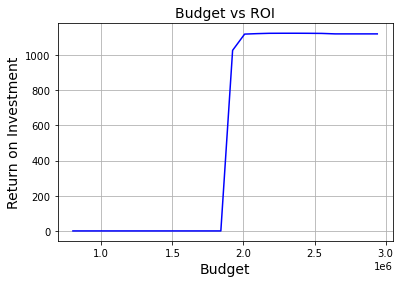

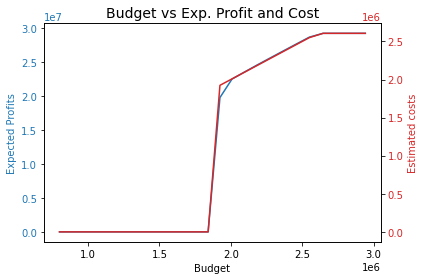

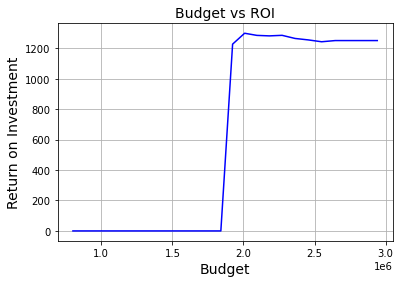

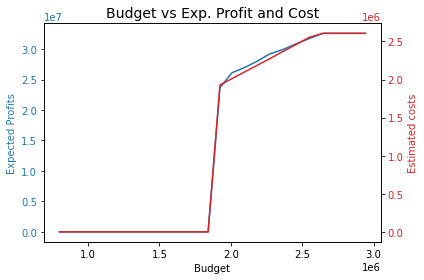

In [177]:
print(business_analysis_tact)

plot_bud_v_roi(budgets, business_analysis_tact)
plot_bud_profit(budgets, business_analysis_tact)

plot_bud_v_roi(budgets, business_analysis_opt)
plot_bud_profit(budgets, business_analysis_opt)



In [178]:
print(budgets)

[800000.0, 830000.0, 868284.2712474618, 911961.5242270663, 960000.0, 1011803.3988749895, 1066969.3845669907, 1125202.5917745214, 1186274.1699796952, 1250000.0, 1316227.766016838, 1384828.726939094, 1455692.1938165305, 1528721.6658103187, 1603832.0341483518, 1680947.5019311125, 1760000.0, 1840927.9563550025, 1923675.3236814712, 2008190.7992727282, 2094427.1909999158, 2182340.8959407266, 2271891.4671611544, 2363041.2503619255, 2455755.0765359257, 2550000.0, 2645745.073534124, 2742961.154130791, 2841620.7341961707, 2941697.794069006]


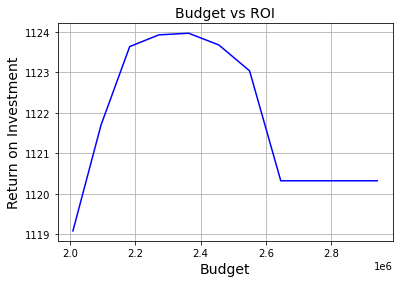

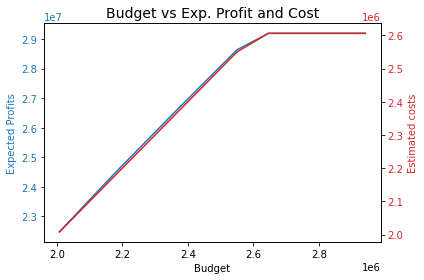

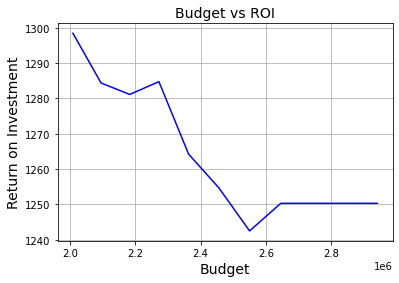

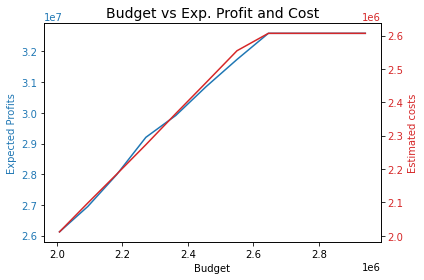

[(22473259.921949778, 2008190.7992727284, 1119.08), (23493252.872054815, 2094427.190999916, 1121.7), (24521590.157626648, 2182340.895940727, 1123.64), (25534425.881492257, 2271891.467161154, 1123.93), (26559777.239541057, 2363041.250361925, 1123.97), (27594852.427911866, 2455755.0765359243, 1123.68), (28637537.258527912, 2549999.999999999, 1123.04), (29196881.54095174, 2606118.6990386494, 1120.32), (29196881.54095174, 2606118.6990386494, 1120.32), (29196881.54095174, 2606118.6990386494, 1120.32), (29196881.54095174, 2606118.6990386494, 1120.32)]
[(26121800.0, 2011800.0, 1298.43), (26947400.0, 2098120.0, 1284.36), (27981000.0, 2184120.0, 1281.11), (29202400.0, 2273040.0, 1284.73), (29912800.0, 2366120.0, 1264.21), (30853600.0, 2459080.0, 1254.68), (31738600.0, 2554440.0, 1242.49), (32590200.0, 2606600.0, 1250.3), (32590200.0, 2606600.0, 1250.3), (32590200.0, 2606600.0, 1250.3), (32590200.0, 2606600.0, 1250.3)]


In [179]:
plot_bud_v_roi(budgets[19:], business_analysis_tact[19:])
plot_bud_profit(budgets[19:], business_analysis_tact[19:])

plot_bud_v_roi(budgets[], business_analysis_opt[19:])
plot_bud_profit(budgets[], business_analysis_opt[19:])

print(business_analysis_tact[19:])
print(business_analysis_opt[19:])

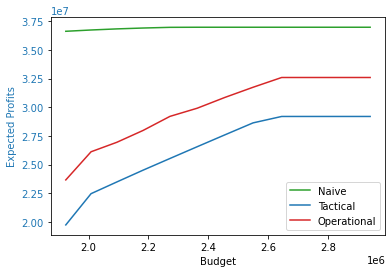

In [203]:

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Budget')
ax1.set_ylabel('Expected Profits', color='tab:blue')
ax1.plot(budgets[18:], [val[0] for val in business_analysis[18:]], color='tab:green', label = "Naive")
ax1.plot(budgets[18:], [val[0] for val in business_analysis_tact[18:]], color='tab:blue', label = "Tactical")
ax1.plot(budgets[18:], [val[0] for val in business_analysis_opt[18:]], color='tab:red', label = "Operational")
ax1.tick_params(axis='y', labelcolor=color)
plt.legend()
plt.show()

In [246]:
M = 10000

budget = 8000

R = 0.1
# Declare and initialize model
mt_ext = gp.Model('Ext_Naive')

print(cust_prods_keys)

### Decisions variables (cust_prod_keys is either 1 or 0)
y = mt_ext.addVars(cust_prods_keys, vtype=GRB.BINARY, name="assign")


z = mt_ext.addVar(name="budget_correction")

const_budget = mt_ext.addConstr((y.prod(expected_cost) - z <= budget), name='budget')

const_minOffers = mt_ext.addConstrs( (y.sum('*',j) >= min_offers[j] for j in products), name='min_offers')

# Constraint to ensure minimum ROI

ROI_con = mt_ext.addConstr((y.prod(expected_profit) - (1 + R)*y.prod(expected_cost) >= 0), name='ROI')

no_offers = mt_ext.addConstrs( (y.sum('c'+str(i),'*') == 1 for i in range(customers)), name='no_offers')

mt_ext.setObjective(y.prod(expected_profit) -M*z, GRB.MAXIMIZE)

mt_ext.write('ext_cust_assign.lp')

mt_ext.optimize()

<gurobi.tuplelist (500 tuples, 2 values each):
 ( c0  , p0 )
 ( c0  , p1 )
 ( c0  , p2 )
 ( c0  , p3 )
 ( c0  , p4 )
 ( c1  , p0 )
 ( c1  , p1 )
 ( c1  , p2 )
 ( c1  , p3 )
 ( c1  , p4 )
 ( c2  , p0 )
 ( c2  , p1 )
 ( c2  , p2 )
 ( c2  , p3 )
 ( c2  , p4 )
 ( c3  , p0 )
 ( c3  , p1 )
 ( c3  , p2 )
 ( c3  , p3 )
 ( c3  , p4 )
 ( c4  , p0 )
 ( c4  , p1 )
 ( c4  , p2 )
 ( c4  , p3 )
 ( c4  , p4 )
 ( c5  , p0 )
 ( c5  , p1 )
 ( c5  , p2 )
 ( c5  , p3 )
 ( c5  , p4 )
 ( c6  , p0 )
 ( c6  , p1 )
 ( c6  , p2 )
 ( c6  , p3 )
 ( c6  , p4 )
 ( c7  , p0 )
 ( c7  , p1 )
 ( c7  , p2 )
 ( c7  , p3 )
 ( c7  , p4 )
 ( c8  , p0 )
 ( c8  , p1 )
 ( c8  , p2 )
 ( c8  , p3 )
 ( c8  , p4 )
 ( c9  , p0 )
 ( c9  , p1 )
 ( c9  , p2 )
 ( c9  , p3 )
 ( c9  , p4 )
 ( c10 , p0 )
 ( c10 , p1 )
 ( c10 , p2 )
 ( c10 , p3 )
 ( c10 , p4 )
 ( c11 , p0 )
 ( c11 , p1 )
 ( c11 , p2 )
 ( c11 , p3 )
 ( c11 , p4 )
 ( c12 , p0 )
 ( c12 , p1 )
 ( c12 , p2 )
 ( c12 , p3 )
 ( c12 , p4 )
 ( c13 , p0 )
 ( c13 , p1 )
 ( c13 , p2 )
 

No other solutions better than -4.77476e+07

Optimal solution found (tolerance 1.00e-04)
Best objective -4.774760000000e+07, best bound -4.774760000000e+07, gap -0.0000%


In [247]:
### Output Reports

# Optimal allocation of product offers to clusters

total_expected_profit = 0
total_expected_cost = 0

print("\nOptimal allocation of product offers to clusters.")
print("___________________________________________________")
for k,p in cust_prods_keys:
    if y[k,p].x > 1e-6:
        #print(y[k,p].varName, y[k,p].x)
        print(f"The number of customers in cluster {k} that gets an offer of product {p} is: {y[k,p].x}")
        total_expected_profit += expected_profit[k,p]*y[k,p].x
        total_expected_cost += expected_cost[k,p]*y[k,p].x

increased_budget = '${:,.2f}'.format(z.x)
print(f"\nThe increase correction in the campaign budget is {increased_budget}.")

# Financial reports

optimal_ROI = round(100*total_expected_profit/total_expected_cost,2)
min_ROI = round(100*(1+R),2)

money_expected_profit = '${:,.2f}'.format(total_expected_profit)
money_expected_cost = '${:,.2f}'.format(total_expected_cost)
money_budget = '${:,.2f}'.format(budget)

print(f"\nFinancial reports.")
print("___________________________________________________")
print(f"Optimal total expected profit is {money_expected_profit}.")
print(f"Optimal total expected cost is {money_expected_cost} with a budget of {money_budget} and an extra amount of {increased_budget}.")
print(f"Optimal ROI is {optimal_ROI}% with a minimum ROI of  {min_ROI}%.")


Optimal allocation of product offers to clusters.
___________________________________________________
The number of customers in cluster c0 that gets an offer of product p1 is: 1.0
The number of customers in cluster c1 that gets an offer of product p4 is: 1.0
The number of customers in cluster c2 that gets an offer of product p4 is: 1.0
The number of customers in cluster c3 that gets an offer of product p2 is: 1.0
The number of customers in cluster c4 that gets an offer of product p1 is: 1.0
The number of customers in cluster c5 that gets an offer of product p1 is: 1.0
The number of customers in cluster c6 that gets an offer of product p0 is: 1.0
The number of customers in cluster c7 that gets an offer of product p3 is: 1.0
The number of customers in cluster c8 that gets an offer of product p2 is: 1.0
The number of customers in cluster c9 that gets an offer of product p4 is: 1.0
The number of customers in cluster c10 that gets an offer of product p3 is: 1.0
The number of customers in 